# Data Cleaning and Exploration Notebook

This notebook is used to import data collected from various sources, clean it, make it uniform and merge it together before exporting it to excel as a dataset containing everything needed for my analysis.


## Contents

1. Setup
2. Import Datasets
    - Convert Data from Wide to Long 
    - Inspect Data
4. Adjust for Population and Inflation and Explore Data
    - Prices
    - Tariffs and Imports
    - U.S. Production
    - Exports
5. Combine Datasets

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime as dt
import calendar
import math
import re
from matplotlib.ticker import FuncFormatter

In [2]:
# Create a map of 3-letter month to 2-digit month
month_map = {'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06', 'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}

In [3]:
# Pathnames for various datasets
avg_price_data = '../data/avg-price-us-cities.xlsx'
tariff_active_data = '../data/ukfrspger_25.xlsx'
ukfrspde_imports_data = '../data/usitc-ukfrspde-imports.xlsx'
world_imports_data = '../data/usitc-world-wine-imports.xlsx'
us_production_data = '../data/wine-prod-ttb.xlsx'
us_exports_data = '../data/exports-monetary-value-and-liters.xlsx'
ppi_data = '../data/PCU3121303121300.xls'
population_data = '../data/POPTHM.xls'
country_level_data = '../data/top-10-wine-exporters-to-us.xlsx'
disposable_income_data = '../data/DSPIC96.csv'

In [4]:
# Making plots a bit more accessible
style.use('fivethirtyeight')
sns.set_palette('colorblind')

## Import Datasets

In [5]:
production_df = pd.read_excel(io=us_production_data, header=3)
exports_dict = pd.read_excel(io=us_exports_data, sheet_name=['FAS Value','First Unit of Quantity'])
wine_prices_df = pd.read_excel(io=avg_price_data)
imports_world_dict = pd.read_excel(world_imports_data, sheet_name=None)
imports_ukfrspde_dict = pd.read_excel(ukfrspde_imports_data, sheet_name=None)
imports_country_dict = pd.read_excel(country_level_data, sheet_name=None)
tariff_df = pd.read_excel(tariff_active_data)
ppi_df = pd.read_excel(io=ppi_data, header=10)
population_df = pd.read_excel(io=population_data, header=10)
disposable_income_df = pd.read_csv(disposable_income_data)

In [6]:
# Create boolean array for highlighting graphs
tariff_active = tariff_df['frspger_25'].astype(bool)

### Convert Data Presentation to Long

The exports and imports datasets are in a wide format where each row corresponds to a year and each column a month of that year. The sheets of these datasets are different datapoints being reported.

I'll want to convert the rows to correspond to months in the format YYYY-MM and the columns to the specific datapoints being reported.

Let's define a function to help convert the datasets.

In [7]:
def wide_to_long(df, col_name):
    df = pd.melt(df, id_vars=['Year'], var_name='month', value_name=col_name)

    df['month'] = df['month'].map(month_map)
    df['month'] = df['Year'].astype(str) + '-' + df['month']

    df.drop(columns='Year', inplace=True)
    return df

Let's add another function to get the last day of the month.

In [8]:
def last_day_of_month(month):
    if pd.isnull(month):
        return

    d = month.split('-')
    date = dt.date(pd.to_numeric(d[0]), pd.to_numeric(d[1]), 1)
    return date.replace(day = calendar.monthrange(date.year, date.month)[1])

We'll also need a time series for joining the data together.

In [9]:
months = pd.date_range('2000-01-01', '2022-01-01', freq='M')

Now we can get the imports data as a long dataset.

We'll first grab the imports data for the entire world and then we'll go and get the data for just the U.K., France, Spain, and Germany.

In [10]:
imports_world_df = pd.DataFrame()
imports_world_df['month'] = months

for name, sheet in imports_world_dict.items():
    if name != 'Query Parameters' and name != 'Query Results':
        sheet_df = pd.DataFrame(sheet)
        sheet_df.columns = sheet_df.iloc[0]
        sheet_df = sheet_df.iloc[1: , :]
        sheet_df = sheet_df[['Year','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]
        
        temp_df = wide_to_long(sheet_df, col_name=name)
        temp_df['month'] = temp_df['month'].map(lambda x: last_day_of_month(x))
        temp_df['month'] = temp_df['month'].astype('datetime64[ns]')
        imports_world_df = imports_world_df.merge(temp_df, on='month')

imports_world_df.sort_values('month', ascending=True, inplace=True)
imports_world_df.head()

,month,Dutiable Value,Landed Duty-Paid Value,Customs Value,First Unit of Quantity,"Charges, Insurance, and Freight",Calculated Duties
0,2000-01-31,133791586,144253063,134876329,30869692,7058649,2318085
1,2000-02-29,140504325,149395178,141089327,27334547,6156122,2149729
2,2000-03-31,168440973,181115109,170803664,33950034,7719881,2591564
3,2000-04-30,174444956,186771728,175506155,37381318,8447127,2818446
4,2000-05-31,177795372,190281882,178396150,38726698,9091316,2794416


Alright, let's pull the data for the countries that the U.S. levvied the higher tariffs on.

In [11]:
imports_ukfrspde_dict = pd.read_excel(ukfrspde_imports_data, sheet_name=None)

imports_ukfrspde_df = pd.DataFrame()
imports_ukfrspde_df['month'] = months
imports_uk_df = imports_ukfrspde_df.copy()
imports_fr_df = imports_ukfrspde_df.copy()
imports_de_df = imports_ukfrspde_df.copy()
imports_sp_df = imports_ukfrspde_df.copy()

for name, sheet in imports_ukfrspde_dict.items():
    if name != 'Query Parameters' and name != 'Query Results':
        sheet_df = pd.DataFrame(sheet)
        sheet_df.columns = sheet_df.iloc[0]
        sheet_df = sheet_df.iloc[1: , :]
        sheet_df = sheet_df[['Country','Year','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]

        temp_fr_df = sheet_df.loc[(sheet_df['Country'] == 'France')]
        temp_de_df = sheet_df.loc[(sheet_df['Country'] == 'Germany')]
        temp_sp_df = sheet_df.loc[(sheet_df['Country'] == 'Spain')]
        temp_uk_df = sheet_df.loc[(sheet_df['Country'] == 'United Kingdom')]
        temp_all_df = sheet_df.loc[(sheet_df['Country'].str.contains('Total'))]
        
        temp_fr_df2 = wide_to_long(temp_fr_df, col_name=name)
        temp_de_df2 = wide_to_long(temp_de_df, col_name=name)
        temp_sp_df2 = wide_to_long(temp_sp_df, col_name=name)
        temp_uk_df2 = wide_to_long(temp_uk_df, col_name=name)
        temp_all_df2 = wide_to_long(temp_all_df, col_name=name)

        temp_fr_df2['month'] = temp_fr_df2['month'].map(lambda x: last_day_of_month(x))
        temp_fr_df2['month'] = temp_fr_df2['month'].astype('datetime64[ns]')
        imports_fr_df = imports_fr_df.merge(temp_fr_df2, on='month')

        temp_de_df2['month'] = temp_de_df2['month'].map(lambda x: last_day_of_month(x))
        temp_de_df2['month'] = temp_de_df2['month'].astype('datetime64[ns]')
        imports_de_df = imports_de_df.merge(temp_de_df2, on='month')

        temp_sp_df2['month'] = temp_sp_df2['month'].map(lambda x: last_day_of_month(x))
        temp_sp_df2['month'] = temp_sp_df2['month'].astype('datetime64[ns]')
        imports_sp_df = imports_sp_df.merge(temp_sp_df2, on='month')

        temp_uk_df2['month'] = temp_uk_df2['month'].map(lambda x: last_day_of_month(x))
        temp_uk_df2['month'] = temp_uk_df2['month'].astype('datetime64[ns]')
        imports_uk_df = imports_uk_df.merge(temp_uk_df2, on='month')

        temp_all_df2['month'] = temp_all_df2['month'].map(lambda x: last_day_of_month(x))
        temp_all_df2['month'] = temp_all_df2['month'].astype('datetime64[ns]')
        imports_ukfrspde_df = imports_ukfrspde_df.merge(temp_all_df2, on='month')

imports_ukfrspde_df.sort_values('month', ascending=True, inplace=True)
imports_ukfrspde_df.head()

,month,"Charges, Insurance, and Freight",Calculated Duties,Dutiable Value,Landed Duty-Paid Value,First Unit of Quantity,Customs Value
0,2000-01-31,2406931,699303,56667673,59812261,8768676,56706027
1,2000-02-29,2356486,857890,73857433,77087577,8961916,73873201
2,2000-03-31,2804317,914008,83440008,87219165,10474993,83500840
3,2000-04-30,2989501,974797,83020862,87040067,11128077,83075769
4,2000-05-31,3037785,897331,75535353,79534639,10874051,75599523


In [12]:
imports_uk_df.head()

,month,"Charges, Insurance, and Freight",Calculated Duties,Dutiable Value,Landed Duty-Paid Value,First Unit of Quantity,Customs Value
0,2000-01-31,5657,3101,297305,306063,23697,297305
1,2000-02-29,4783,3995,205078,213856,24643,205078
2,2000-03-31,5246,6647,390139,402032,93611,390139
3,2000-04-30,16395,14525,654145,685065,87071,654145
4,2000-05-31,11984,3143,1019724,1034851,31949,1019724


### Let's make a panel dataset of the country-level data

In [13]:
imports_country_df = pd.DataFrame()

for name, sheet in imports_country_dict.items():
    if name != 'Query Parameters' and name != 'Query Results':
        sheet_df = pd.DataFrame(sheet)
        test_df = pd.melt(sheet_df, id_vars=['Year', 'Country'], var_name='month', value_name=name)

        test_df['month'] = test_df['month'].map(month_map)
        test_df['month'] = test_df['Year'].astype(str) + '-' + test_df['month']
        test_df['month'] = test_df['month'].map(lambda x: last_day_of_month(x))
        test_df['month'] = test_df['month'].astype('datetime64[ns]')
        test_df.drop(columns='Year', inplace=True)

        if imports_country_df.empty:
            imports_country_df = test_df.copy()
        else:
            imports_country_df = imports_country_df.merge(test_df, on=['month', 'Country'])

In [14]:
imports_country_df.head(50)

,Country,month,"Charges, Insurance, and Freight",Calculated Duties,Dutiable Value,Landed Duty-Paid Value,First Unit of Quantity,Customs Value
0,Argentina,2000-01-31,134852,62570,2153303,2350725,902513,2153303
1,Australia,2000-01-31,817000,284768,20464802,21566570,4151994,20464802
2,Canada,2000-01-31,1090,0,0,44776,3118,43686
3,Chile,2000-01-31,1089308,454811,13779675,15348021,5715396,13803902
4,France,2000-01-31,1923749,530460,48323671,50816234,6956138,48362025
5,Germany,2000-01-31,196654,56622,2903606,3156882,855964,2903606
6,Italy,2000-01-31,2178018,711564,34911156,37807117,9831208,34917535
7,New Zealand,2000-01-31,73642,13944,1161151,1248737,221164,1161151
8,Portugal,2000-01-31,110525,41070,2072879,2226666,394686,2075071
9,South Africa,2000-01-31,38675,8433,653989,701097,132921,653989


Let's take out the top 3 countries that aren't included in the bloc of countries subject to the additional tariff.

In [15]:
country = []
average_imports = []
for c in imports_country_df['Country'].unique():
    if c != 'World':
        c_df = imports_country_df.loc[imports_country_df['Country'] == c].copy()
        c_df.sort_values(by='month')
        c_df['weight'] = 1 + np.arange(len(c_df)) / len(c_df)
        monthly_avg_q = np.average(c_df['First Unit of Quantity'], weights=c_df['weight'])
        country.append(c)
        average_imports.append(monthly_avg_q)

average_imports_by_country_df =  pd.DataFrame({'country': country, 'avg_imp_q': average_imports})
display(average_imports_by_country_df.nlargest(7, 'avg_imp_q'))

,country,avg_imp_q
6,Italy,2.238664e+07
1,Australia,1.375422e+07
4,France,1.034120e+07
3,Chile,8.863492e+06
0,Argentina,5.621417e+06
10,Spain,4.552465e+06
2,Canada,4.051553e+06


We'll need to use the ppi data to merge this in.

In [16]:
# Get the last day of the month
ppi_df['month'] = ppi_df['observation_date'].map(lambda x: str(x.year) + '-' + '{:02d}'.format(x.month))
ppi_df['month'] = ppi_df['month'].map(lambda x: last_day_of_month(x))
ppi_df['month'] = ppi_df['month'].astype('datetime64[ns]')

In [17]:
country = ['Italy', 'Australia', 'Chile']

# merge in ppi data
imports_by_country_df = imports_country_df.merge(ppi_df[['month', 'PCU3121303121300']], how='left', left_on='month', right_on='month')

In [18]:
top_three_df = pd.DataFrame()
top_three_df['month'] = months

for c in country:
    c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
    c_df.rename(columns={
        'Charges, Insurance, and Freight': 'charges_insurance_freight',
        'Calculated Duties': 'calculated_duties',
        'Dutiable Value': 'dutiable_value',
        'Landed Duty-Paid Value': 'landed_duty_paid_value',
        'First Unit of Quantity': 'quantity',
        'Customs Value': 'customs_value',
        'PCU3121303121300': 'ppi'
    }, inplace=True)

    cols_to_merge = ['month']
    for col in c_df.columns:
        if col != 'ppi' and col != 'month' and col != 'Country':
            col_name = col + '_' + c.lower() + '_imports'
            col_name_adj = col + '_adj_' + c.lower() + '_imports'
            cols_to_merge.append(col_name)
            cols_to_merge.append(col_name_adj)
            
            c_df[col_name] = c_df[col]
            c_df[col_name_adj] = c_df[col_name] / c_df['ppi'] * 100
    top_three_df = top_three_df.merge(c_df[cols_to_merge], on='month')


In [81]:
top_three_df['cif_top3_adj'] = top_three_df['charges_insurance_freight_adj_italy_imports'] + top_three_df['charges_insurance_freight_adj_chile_imports'] + top_three_df['charges_insurance_freight_adj_australia_imports']
top_three_df['calc_duties_top3_adj'] = top_three_df['calculated_duties_adj_italy_imports'] + top_three_df['calculated_duties_adj_chile_imports'] + top_three_df['calculated_duties_adj_australia_imports']
top_three_df['duty_val_top3_adj'] = top_three_df['dutiable_value_adj_italy_imports'] + top_three_df['dutiable_value_adj_chile_imports'] + top_three_df['dutiable_value_adj_australia_imports']
top_three_df['duty_paid_val_top3_adj'] = top_three_df['landed_duty_paid_value_adj_italy_imports'] + top_three_df['landed_duty_paid_value_adj_chile_imports'] + top_three_df['landed_duty_paid_value_adj_australia_imports']
top_three_df['quantity_top3'] = top_three_df['quantity_italy_imports'] + top_three_df['quantity_chile_imports'] + top_three_df['quantity_australia_imports']
top_three_df['customs_value_top3_adj'] = top_three_df['customs_value_adj_italy_imports'] + top_three_df['customs_value_adj_chile_imports'] + top_three_df['customs_value_adj_australia_imports']


,month,charges_insurance_freight_italy_imports,charges_insurance_freight_adj_italy_imports,calculated_duties_italy_imports,calculated_duties_adj_italy_imports,dutiable_value_italy_imports,dutiable_value_adj_italy_imports,landed_duty_paid_value_italy_imports,landed_duty_paid_value_adj_italy_imports,quantity_italy_imports,...,calculated_duties_chile_imports,calculated_duties_adj_chile_imports,dutiable_value_chile_imports,dutiable_value_adj_chile_imports,landed_duty_paid_value_chile_imports,landed_duty_paid_value_adj_chile_imports,quantity_chile_imports,quantity_adj_chile_imports,customs_value_chile_imports,customs_value_adj_chile_imports
0,2000-01-31,2178018,2.114581e+06,711564,690838.834951,34911156,3.389433e+07,37807117,3.670594e+07,9831208,...,454811,441564.077670,13779675,1.337833e+07,15348021,1.490099e+07,5715396,5.548928e+06,13803902,1.340185e+07
1,2000-02-29,2004039,1.982234e+06,662234,655028.684471,32277447,3.192626e+07,34972313,3.459180e+07,9282644,...,205758,203519.287834,8940527,8.843251e+06,9735653,9.629726e+06,3264892,3.229369e+06,8943127,8.845823e+06
2,2000-03-31,2601141,2.525380e+06,945602,918060.194175,41479822,4.027167e+07,45136245,4.382160e+07,12421221,...,218589,212222.330097,9171712,8.904575e+06,10050403,9.757673e+06,3388873,3.290168e+06,9174884,8.907654e+06
3,2000-04-30,2860026,2.831709e+06,984012,974269.306931,46937547,4.647282e+07,50882296,5.037851e+07,13778866,...,392453,388567.326733,12720153,1.259421e+07,14115589,1.397583e+07,5479438,5.425186e+06,12720153,1.259421e+07
4,2000-05-31,3244199,3.183709e+06,989090,970647.693817,49934400,4.900334e+07,54209473,5.319870e+07,14761482,...,277489,272315.014720,11648651,1.143145e+07,12810803,1.257194e+07,4417065,4.334706e+06,11683256,1.146541e+07


In [19]:
imports_country_df.to_excel('../data/imports-to-us-panel.xlsx')

In [20]:
test_df.head()

,Country,month,Customs Value
0,Argentina,2000-01-31,2153303
1,Australia,2000-01-31,20464802
2,Canada,2000-01-31,43686
3,Chile,2000-01-31,13803902
4,France,2000-01-31,48362025


<AxesSubplot:ylabel='First Unit of Quantity'>

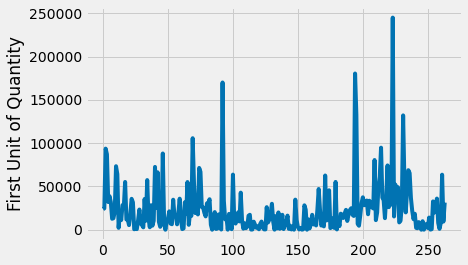

In [21]:
sns.lineplot(data=imports_uk_df['First Unit of Quantity'].astype('f4'))

Now let's make the exports data long.

In [22]:
for name, sheet in exports_dict.items():
    if name == 'FAS Value':
        exports_value_df = pd.DataFrame(sheet)
        exports_value_df.columns = exports_value_df.iloc[0]
        exports_value_df = exports_value_df.iloc[1: , :]
        exports_value_df = wide_to_long(exports_value_df, col_name=name)
    if name == 'First Unit of Quantity':
        exports_quantity_df = pd.DataFrame(sheet)
        exports_quantity_df.columns = exports_quantity_df.iloc[0]
        exports_quantity_df = exports_quantity_df.iloc[1: , :]
        exports_quantity_df = wide_to_long(exports_quantity_df, col_name=name)

exports_df = exports_value_df.merge(exports_quantity_df, on='month')

# There are 108 empty rows at the bottom of the dataframe due to extra cells in the 
# excel spreadsheet. After checking, these are the only empty rows and dropping them
# leaves 264 entries, as there should be.
exports_df.dropna(inplace=True)

exports_df['month'] = exports_df['month'].map(lambda x: last_day_of_month(x))
exports_df.sort_values('month', ascending=True, inplace=True)

exports_df.head()

,month,FAS Value,First Unit of Quantity
0,2000-01-31,45525687,22385348
31,2000-02-29,41336082,20954045
62,2000-03-31,41446856,20240059
93,2000-04-30,41411758,21745478
124,2000-05-31,42672115,22059299


### Inspect Data

Here I'll provide summary statistics for each of the datasets before we go on to do any transformations on the data.

#### Producer Price Index

I'm going to adjust for inflation using the industry-specific series for the producer price index as provided by the Federal Reserve (FRED). I'm doing this because most of the data used is production-side and this provides a more-specific inflation adjustment for this industry than the regular CPI.

The series is PCU3121303121300.

FRED summarizes the dataset as follows:
    Producer Price Index by Industry: Wineries: Wines, Brandy, and Brandy Spirits, Index Dec 1998=100, Monthly, Not Seasonally Adjusted

In [23]:
display(ppi_df.head())
display(ppi_df.info())
display(ppi_df.describe())

,observation_date,PCU3121303121300,month
0,2000-01-01,103.0,2000-01-31
1,2000-02-01,101.1,2000-02-29
2,2000-03-01,103.0,2000-03-31
3,2000-04-01,101.0,2000-04-30
4,2000-05-01,101.9,2000-05-31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  265 non-null    datetime64[ns]
 1   PCU3121303121300  265 non-null    float64       
 2   month             265 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1)
memory usage: 6.3 KB


None

,PCU3121303121300
count,265.000000
mean,116.637834
std,9.501049
min,100.900000
25%,106.000000
50%,118.800000
75%,123.400000
max,134.442000


### Disposable Income

Real disposable personal income data is provided by FRED. This series comes already adjusted for inflation. The series id is DSPIC96. It's originally collected by the U.S. Bureau of Economic Analysis in the Personal Income and Outlays release. The dataset is in billions of chained 2012 dollars and is seasonally adjusted.

Suggested citation: U.S. Bureau of Economic Analysis, Real Disposable Personal Income [DSPIC96], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DSPIC96, April 9, 2022.

Let's update disposable income data.

In [24]:
disposable_income_df.head()
disposable_income_df['DATE'] = disposable_income_df['DATE'].astype('datetime64[ns]')
disposable_income_df['month'] = disposable_income_df['DATE'].map(lambda x: str(x.year) + '-' + '{:02d}'.format(x.month))
disposable_income_df['month'] = disposable_income_df['month'].map(lambda x: last_day_of_month(x))
disposable_income_df['month'] = disposable_income_df['month'].astype('datetime64[ns]')
disposable_income_df['di'] = disposable_income_df['DSPIC96']

In [25]:
display(disposable_income_df.info())
display(disposable_income_df.describe())
display(disposable_income_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     266 non-null    datetime64[ns]
 1   DSPIC96  266 non-null    float64       
 2   month    266 non-null    datetime64[ns]
 3   di       266 non-null    float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 8.4 KB


None

,DSPIC96,di
count,266.000000,266.000000
mean,12315.428571,12315.428571
std,1854.758885,1854.758885
min,9309.100000,9309.100000
25%,10843.400000,10843.400000
50%,12061.100000,12061.100000
75%,13575.950000,13575.950000
max,19119.500000,19119.500000


,DATE,DSPIC96,month,di
0,2000-01-01,9309.1,2000-01-31,9309.1
1,2000-02-01,9345.2,2000-02-29,9345.2
2,2000-03-01,9370.3,2000-03-31,9370.3
3,2000-04-01,9418.3,2000-04-30,9418.3
4,2000-05-01,9457.3,2000-05-31,9457.3


#### U.S. Population

Population Data provided by the Federal Reserve (FRED). I'll be using this to adjust for per-capita wine quantities. This data is presently in thousands.

POPTHM:
Population, Thousands, Monthly, Not Seasonally Adjusted

In [26]:
population_df['month'] = population_df['observation_date'].map(lambda x: str(x.year) + '-' + '{:02d}'.format(x.month))
population_df['month'] = population_df['month'].map(lambda x: last_day_of_month(x))
population_df['month'] = population_df['month'].astype('datetime64[ns]')
population_df['population'] = population_df['POPTHM'] * 1000

In [27]:
display(population_df.info())
display(population_df.describe())
display(population_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  264 non-null    datetime64[ns]
 1   POPTHM            264 non-null    int64         
 2   month             264 non-null    datetime64[ns]
 3   population        264 non-null    int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 8.4 KB


None

,POPTHM,population
count,264.000000,2.640000e+02
mean,309321.689394,3.093217e+08
std,15255.933065,1.525593e+07
min,281083.000000,2.810830e+08
25%,296013.750000,2.960138e+08
50%,310940.500000,3.109405e+08
75%,323112.000000,3.231120e+08
max,331895.000000,3.318950e+08


,observation_date,POPTHM,month,population
0,2000-01-01,281083,2000-01-31,281083000
1,2000-02-01,281299,2000-02-29,281299000
2,2000-03-01,281531,2000-03-31,281531000
3,2000-04-01,281763,2000-04-30,281763000
4,2000-05-01,281996,2000-05-31,281996000


<AxesSubplot:xlabel='month', ylabel='POPTHM'>

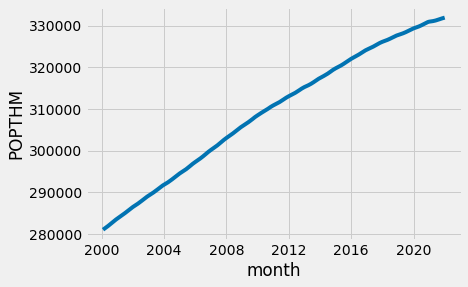

In [28]:
sns.lineplot(data=population_df, x='month', y='POPTHM')

#### World Imports

In [29]:
display(imports_world_df.head())
display(imports_world_df.describe())
display(imports_world_df.info())

,month,Dutiable Value,Landed Duty-Paid Value,Customs Value,First Unit of Quantity,"Charges, Insurance, and Freight",Calculated Duties
0,2000-01-31,133791586,144253063,134876329,30869692,7058649,2318085
1,2000-02-29,140504325,149395178,141089327,27334547,6156122,2149729
2,2000-03-31,168440973,181115109,170803664,33950034,7719881,2591564
3,2000-04-30,174444956,186771728,175506155,37381318,8447127,2818446
4,2000-05-31,177795372,190281882,178396150,38726698,9091316,2794416


<ipython-input-29-09d884bef029>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(imports_world_df.describe())


,month,Dutiable Value,Landed Duty-Paid Value,Customs Value,First Unit of Quantity,"Charges, Insurance, and Freight",Calculated Duties
count,264,264.0,264.0,264.0,264.0,264.0,264.0
unique,264,264.0,264.0,264.0,264.0,264.0,264.0
top,2009-05-31 00:00:00,387436035.0,389987329.0,305807449.0,67360257.0,12248065.0,5050881.0
freq,1,1.0,1.0,1.0,1.0,1.0,1.0
first,2000-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   month                            264 non-null    datetime64[ns]
 1   Dutiable Value                   264 non-null    object        
 2   Landed Duty-Paid Value           264 non-null    object        
 3   Customs Value                    264 non-null    object        
 4   First Unit of Quantity           264 non-null    object        
 5   Charges, Insurance, and Freight  264 non-null    object        
 6   Calculated Duties                264 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 16.5+ KB


None

I'll clean up some of these variable names to make them cleaner.

In [30]:
def reformat_column_names(col_name):
    return str.lower(re.subn(' |, |-', '_', col_name)[0])

Before looking into the values' distributions, I'm going to adjust for inflation and population.

In [31]:
imports_world_df = imports_world_df.merge(ppi_df, on='month')
imports_world_df = imports_world_df.merge(population_df[['month', 'population']], on='month')

for c in imports_world_df.columns:
    col_name = reformat_column_names(c) + '_adj'
    if c == 'population':
        imports_world_df['wine_quantity_per_capita'] = imports_world_df['First Unit of Quantity'] / imports_world_df[c].astype('f4')
    elif c != 'First Unit of Quantity' and c != 'month' and c != 'PCU3121303121300' and c != 'observation_date':
        imports_world_df[col_name] = imports_world_df[c] / imports_world_df['PCU3121303121300'] * 100
        
imports_world_df.head()

,month,Dutiable Value,Landed Duty-Paid Value,Customs Value,First Unit of Quantity,"Charges, Insurance, and Freight",Calculated Duties,observation_date,PCU3121303121300,population,dutiable_value_adj,landed_duty_paid_value_adj,customs_value_adj,charges_insurance_and_freight_adj,calculated_duties_adj,wine_quantity_per_capita
0,2000-01-31,133791586,144253063,134876329,30869692,7058649,2318085,2000-01-01,103.0,281083000,129894743.68932,140051517.475728,130947892.23301,6853057.281553,2250567.961165,0.109824
1,2000-02-29,140504325,149395178,141089327,27334547,6156122,2149729,2000-02-01,101.1,281299000,138975593.47181,147769711.177052,139554230.464886,6089141.444115,2126339.268051,0.097173
2,2000-03-31,168440973,181115109,170803664,33950034,7719881,2591564,2000-03-01,103.0,281531000,163534925.242718,175839911.650485,165828800.0,7495030.097087,2516081.553398,0.120591
3,2000-04-30,174444956,186771728,175506155,37381318,8447127,2818446,2000-04-01,101.0,281763000,172717778.217822,184922502.970297,173768470.29703,8363492.079208,2790540.594059,0.132669
4,2000-05-31,177795372,190281882,178396150,38726698,9091316,2794416,2000-05-01,101.9,281996000,174480247.301276,186733937.193327,175069823.356232,8921801.766438,2742312.070658,0.137331


<AxesSubplot:xlabel='value', ylabel='variable'>

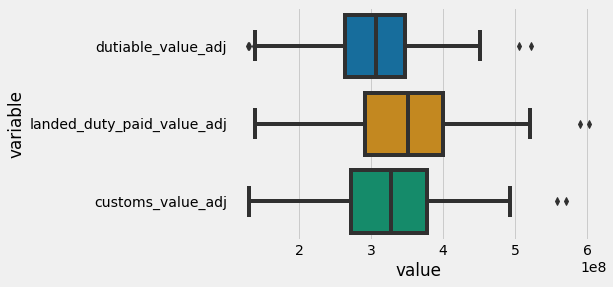

In [32]:
imports_value_boxplot_data = pd.melt(imports_world_df[['dutiable_value_adj', 'landed_duty_paid_value_adj', 'customs_value_adj']])
sns.boxplot(data=imports_value_boxplot_data, y='variable', x='value')

<AxesSubplot:xlabel='value', ylabel='variable'>

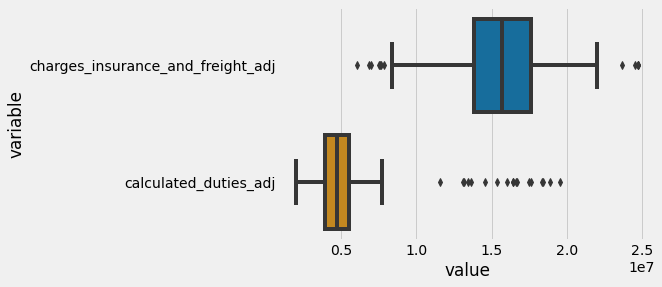

In [33]:
imports_boxplot_data = pd.melt(imports_world_df[['charges_insurance_and_freight_adj', 'calculated_duties_adj']])
sns.boxplot(data=imports_boxplot_data, y='variable', x='value')

<AxesSubplot:>

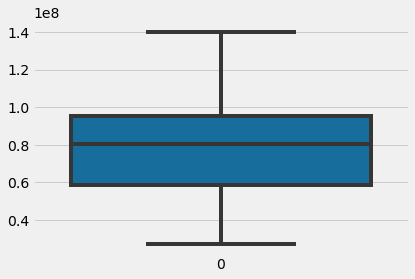

In [34]:
sns.boxplot(data=imports_world_df['First Unit of Quantity'])

<AxesSubplot:>

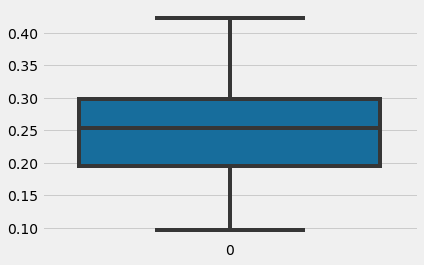

In [35]:
sns.boxplot(data=imports_world_df['wine_quantity_per_capita'])

#### U.K., France, Germany, Spain Imports

In [36]:
imports_ukfrspde_df = imports_ukfrspde_df.merge(ppi_df, on='month')
imports_ukfrspde_df = imports_ukfrspde_df.merge(population_df[['month', 'population']], on='month')

for c in imports_ukfrspde_df.columns:
    if c == 'population':
        imports_ukfrspde_df['wine_quantity_per_capita'] = imports_ukfrspde_df['First Unit of Quantity'] / imports_ukfrspde_df['population']
    elif c != 'First Unit of Quantity' and c != 'month' and c != 'PCU3121303121300' and c != 'observation_date':
        col_name = reformat_column_names(c) + '_adj'
        imports_ukfrspde_df[col_name] = imports_ukfrspde_df[c] / imports_ukfrspde_df['PCU3121303121300'] * 100

imports_ukfrspde_df.head()

,month,"Charges, Insurance, and Freight",Calculated Duties,Dutiable Value,Landed Duty-Paid Value,First Unit of Quantity,Customs Value,observation_date,PCU3121303121300,population,charges_insurance_and_freight_adj,calculated_duties_adj,dutiable_value_adj,landed_duty_paid_value_adj,customs_value_adj,wine_quantity_per_capita
0,2000-01-31,2406931,699303,56667673,59812261,8768676,56706027,2000-01-01,103.0,281083000,2336826.213592,678934.951456,55017158.252427,58070156.31068,55054395.145631,0.031196
1,2000-02-29,2356486,857890,73857433,77087577,8961916,73873201,2000-02-01,101.1,281299000,2330846.686449,848555.885262,73053840.751731,76248839.762611,73069437.1909,0.031859
2,2000-03-31,2804317,914008,83440008,87219165,10474993,83500840,2000-03-01,103.0,281531000,2722637.864078,887386.407767,81009716.504854,84678800.970874,81068776.699029,0.037207
3,2000-04-30,2989501,974797,83020862,87040067,11128077,83075769,2000-04-01,101.0,281763000,2959901.980198,965145.544554,82198873.267327,86178284.158416,82253236.633663,0.039494
4,2000-05-31,3037785,897331,75535353,79534639,10874051,75599523,2000-05-01,101.9,281996000,2981143.277723,880599.607458,74126941.118744,78051657.50736,74189914.622179,0.038561


In [37]:
display(imports_ukfrspde_df.head())
display(imports_ukfrspde_df.describe())
display(imports_ukfrspde_df.info())

,month,"Charges, Insurance, and Freight",Calculated Duties,Dutiable Value,Landed Duty-Paid Value,First Unit of Quantity,Customs Value,observation_date,PCU3121303121300,population,charges_insurance_and_freight_adj,calculated_duties_adj,dutiable_value_adj,landed_duty_paid_value_adj,customs_value_adj,wine_quantity_per_capita
0,2000-01-31,2406931,699303,56667673,59812261,8768676,56706027,2000-01-01,103.0,281083000,2336826.213592,678934.951456,55017158.252427,58070156.31068,55054395.145631,0.031196
1,2000-02-29,2356486,857890,73857433,77087577,8961916,73873201,2000-02-01,101.1,281299000,2330846.686449,848555.885262,73053840.751731,76248839.762611,73069437.1909,0.031859
2,2000-03-31,2804317,914008,83440008,87219165,10474993,83500840,2000-03-01,103.0,281531000,2722637.864078,887386.407767,81009716.504854,84678800.970874,81068776.699029,0.037207
3,2000-04-30,2989501,974797,83020862,87040067,11128077,83075769,2000-04-01,101.0,281763000,2959901.980198,965145.544554,82198873.267327,86178284.158416,82253236.633663,0.039494
4,2000-05-31,3037785,897331,75535353,79534639,10874051,75599523,2000-05-01,101.9,281996000,2981143.277723,880599.607458,74126941.118744,78051657.50736,74189914.622179,0.038561


,PCU3121303121300,population
count,264.000000,2.640000e+02
mean,116.571076,3.093217e+08
std,9.456620,1.525593e+07
min,100.900000,2.810830e+08
25%,105.925000,2.960138e+08
50%,118.800000,3.109405e+08
75%,123.175000,3.231120e+08
max,134.442000,3.318950e+08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   month                              264 non-null    datetime64[ns]
 1   Charges, Insurance, and Freight    264 non-null    object        
 2   Calculated Duties                  264 non-null    object        
 3   Dutiable Value                     264 non-null    object        
 4   Landed Duty-Paid Value             264 non-null    object        
 5   First Unit of Quantity             264 non-null    object        
 6   Customs Value                      264 non-null    object        
 7   observation_date                   264 non-null    datetime64[ns]
 8   PCU3121303121300                   264 non-null    float64       
 9   population                         264 non-null    int64         
 10  charges_insurance_and_freight_adj  264

None

<AxesSubplot:xlabel='value', ylabel='variable'>

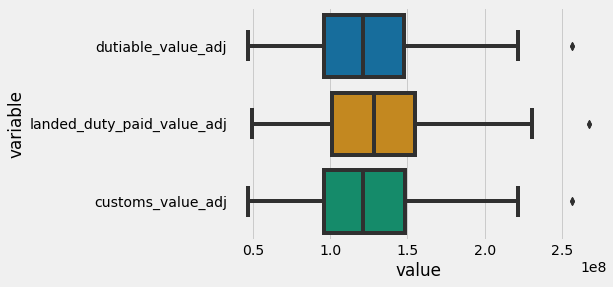

In [38]:
imports_value_boxplot_ukfrspde_df = pd.melt(imports_ukfrspde_df[['dutiable_value_adj', 'landed_duty_paid_value_adj', 'customs_value_adj']])
sns.boxplot(data=imports_value_boxplot_ukfrspde_df, y='variable', x='value')

<AxesSubplot:xlabel='value', ylabel='variable'>

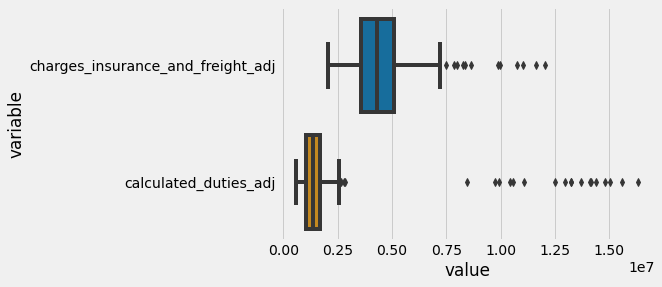

In [39]:
imports_boxplot_ukfrspde_df = pd.melt(imports_ukfrspde_df[['charges_insurance_and_freight_adj', 'calculated_duties_adj']])
sns.boxplot(data=imports_boxplot_ukfrspde_df, y='variable', x='value')

<AxesSubplot:>

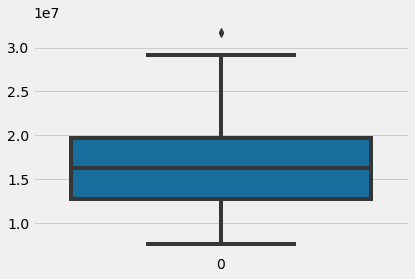

In [40]:
sns.boxplot(data=imports_ukfrspde_df['First Unit of Quantity'])

<AxesSubplot:>

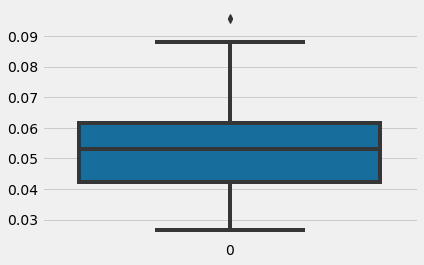

In [41]:
sns.boxplot(data=imports_ukfrspde_df['wine_quantity_per_capita'])

Let's look at some differences in the duties between the set of countries this additional tariff was put on and the rest of the world.

In [42]:
various_duties_df = imports_world_df[['month']]

various_duties_df['world_average_duties'] = (imports_world_df['calculated_duties_adj'] - imports_ukfrspde_df['calculated_duties_adj']) / (imports_world_df['dutiable_value_adj'] - imports_ukfrspde_df['dutiable_value_adj'])
various_duties_df['world_average_duties'] = various_duties_df['world_average_duties'].astype('f4')

various_duties_df['ukfrspde_average_duties'] = imports_ukfrspde_df['calculated_duties_adj'] / imports_ukfrspde_df['dutiable_value_adj']
various_duties_df['ukfrspde_average_duties'] = various_duties_df['ukfrspde_average_duties'].astype('f4')

<ipython-input-42-a217a26162e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['world_average_duties'] = (imports_world_df['calculated_duties_adj'] - imports_ukfrspde_df['calculated_duties_adj']) / (imports_world_df['dutiable_value_adj'] - imports_ukfrspde_df['dutiable_value_adj'])
<ipython-input-42-a217a26162e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['world_average_duties'] = various_duties_df['world_average_duties'].astype('f4')
<ipython-input-42-a217a26162e

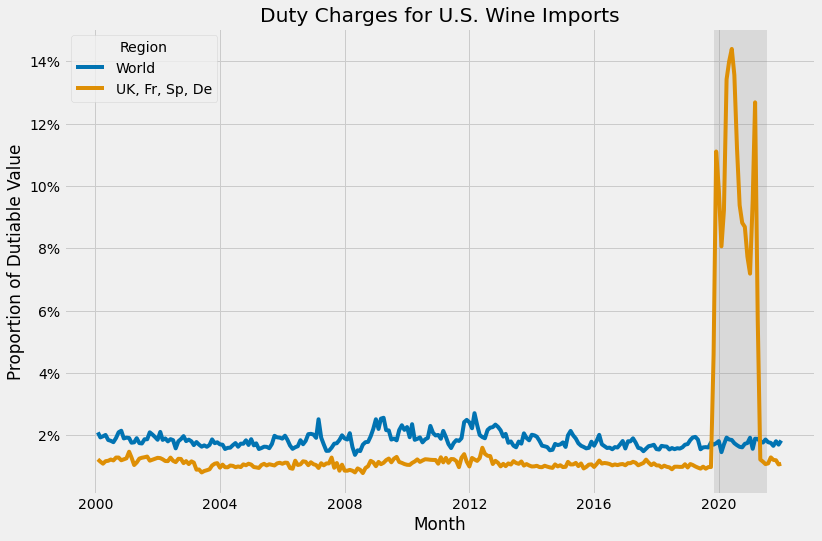

In [43]:
duties_plot = sns.lineplot(data=pd.melt(various_duties_df, ['month']), x='month', y='value', hue='variable',)
duties_plot.set(title='Duty Charges for U.S. Wine Imports', xlabel='Month', ylabel='Proportion of Dutiable Value')
duties_plot.axvspan(
    xmin=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).first_valid_index()], 
    xmax=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).last_valid_index()], 
    color='gray', 
    alpha=0.2
)
duties_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.legend(title='Region', loc='upper left', labels=['World', 'UK, Fr, Sp, De'])
plt.savefig('../figures/duty-charges-for-wine-imports.png')
plt.show(duties_plot)



In [44]:
various_duties_df['ukfrspde_quantity'] = imports_ukfrspde_df['First Unit of Quantity'] / 1000000
various_duties_df['ukfrspde_quantity'] = various_duties_df['ukfrspde_quantity'].astype('f4')
various_duties_df['world_quantity'] = (imports_world_df['First Unit of Quantity'] - imports_ukfrspde_df['First Unit of Quantity']) / 1000000
various_duties_df['world_quantity'] = various_duties_df['world_quantity'].astype('f4')

<ipython-input-44-c73036fe9bad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_quantity'] = imports_ukfrspde_df['First Unit of Quantity'] / 1000000
<ipython-input-44-c73036fe9bad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_quantity'] = various_duties_df['ukfrspde_quantity'].astype('f4')
<ipython-input-44-c73036fe9bad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

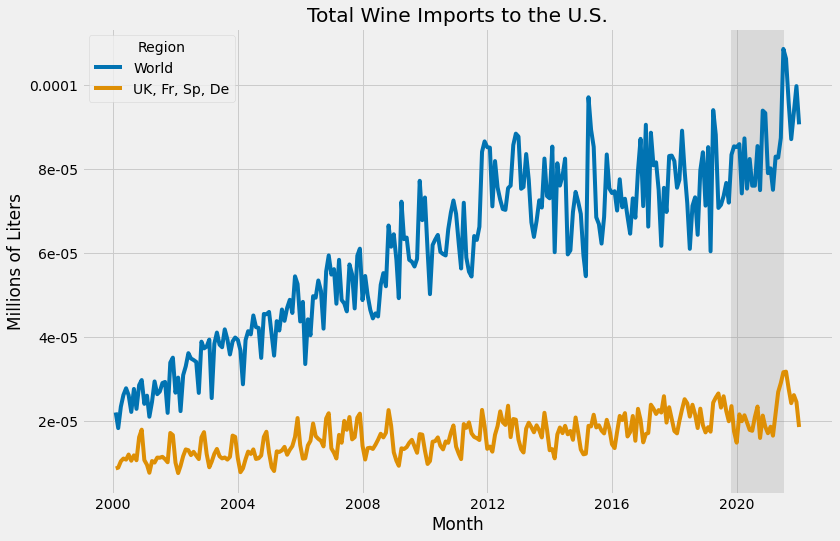

In [45]:
imports_quantity_plot = sns.lineplot(data=pd.melt(various_duties_df[['month', 'world_quantity', 'ukfrspde_quantity']], ['month']), x='month', y='value', hue='variable',)
imports_quantity_plot.set(title='Total Wine Imports to the U.S.', xlabel='Month', ylabel='Millions of Liters')
imports_quantity_plot.axvspan(
    xmin=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).first_valid_index()], 
    xmax=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).last_valid_index()], 
    color='gray', 
    alpha=0.2
)
imports_quantity_plot.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6)))
plt.gcf().set_size_inches(12, 8)

plt.legend(title='Region', loc='upper left', labels=['World', 'UK, Fr, Sp, De'])
plt.savefig('../figures/total-wine-imports-to-the-us.png')
plt.show()

<ipython-input-46-1b6560be979d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_quantity'] = imports_ukfrspde_df['First Unit of Quantity']
<ipython-input-46-1b6560be979d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_quantity'] = various_duties_df['ukfrspde_quantity'].astype('f4')
<ipython-input-46-1b6560be979d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

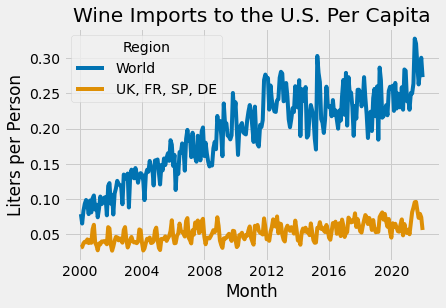

In [46]:
various_duties_df['ukfrspde_quantity'] = imports_ukfrspde_df['First Unit of Quantity']
various_duties_df['ukfrspde_quantity'] = various_duties_df['ukfrspde_quantity'].astype('f4')
various_duties_df['ukfrspde_quantity_per_capita'] = various_duties_df['ukfrspde_quantity'] / imports_ukfrspde_df['population']
various_duties_df['world_quantity'] = (imports_world_df['First Unit of Quantity'] - imports_ukfrspde_df['First Unit of Quantity'])
various_duties_df['world_quantity'] = various_duties_df['world_quantity'].astype('f4')
various_duties_df['world_quantity_per_capita'] = various_duties_df['world_quantity'] / imports_world_df['population']

imports_quantity_plot = sns.lineplot(data=pd.melt(various_duties_df[['month', 'world_quantity_per_capita', 'ukfrspde_quantity_per_capita']], ['month']), x='month', y='value', hue='variable',)
imports_quantity_plot.set(title='Wine Imports to the U.S. Per Capita', xlabel='Month', ylabel='Liters per Person')

plt.legend(title='Region', loc='upper left', labels=['World', 'UK, FR, SP, DE'])
plt.show()


In [47]:
various_duties_df['ukfrspde_percentage'] = various_duties_df['ukfrspde_quantity'] / (various_duties_df['world_quantity'] + various_duties_df['ukfrspde_quantity'])
various_duties_df['ukfrspde_percentage'] = various_duties_df['ukfrspde_percentage'].astype('f4')
various_duties_df['percentage_rolling_avg_7'] = various_duties_df.ukfrspde_percentage.rolling(7).mean()

<ipython-input-47-70ebe657ed58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_percentage'] = various_duties_df['ukfrspde_quantity'] / (various_duties_df['world_quantity'] + various_duties_df['ukfrspde_quantity'])
<ipython-input-47-70ebe657ed58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  various_duties_df['ukfrspde_percentage'] = various_duties_df['ukfrspde_percentage'].astype('f4')
<ipython-input-47-70ebe657ed58>:3: SettingWithCopyWarning: 
A value is trying to be set on

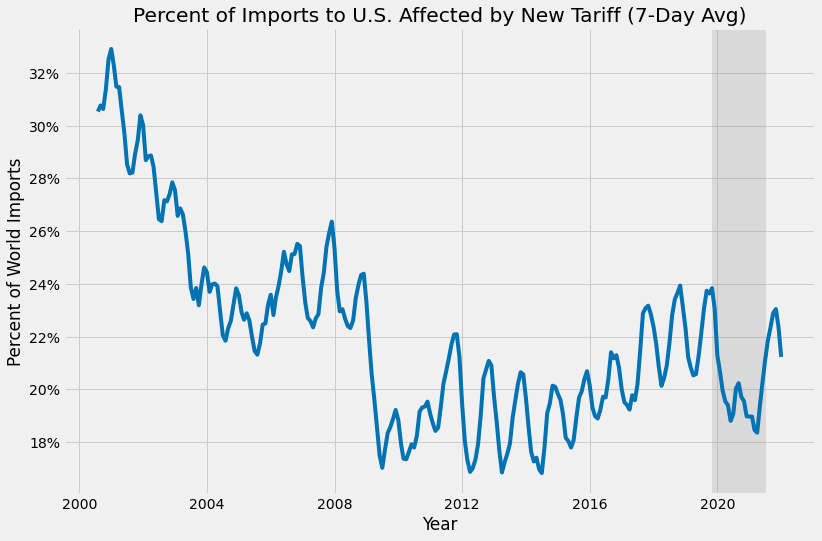

In [48]:
percentage_rolling_avg_plot = sns.lineplot(x='month', y='percentage_rolling_avg_7', data=various_duties_df)
percentage_rolling_avg_plot.set(title='Percent of Imports to U.S. Affected by New Tariff (7-Day Avg)', xlabel='Year', ylabel='Percent of World Imports')
percentage_rolling_avg_plot.axvspan(
    xmin=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).first_valid_index()], 
    xmax=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).last_valid_index()], 
    color='gray', 
    alpha=0.2
)
percentage_rolling_avg_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/percent-of-world-imports-affected.png')
plt.show()

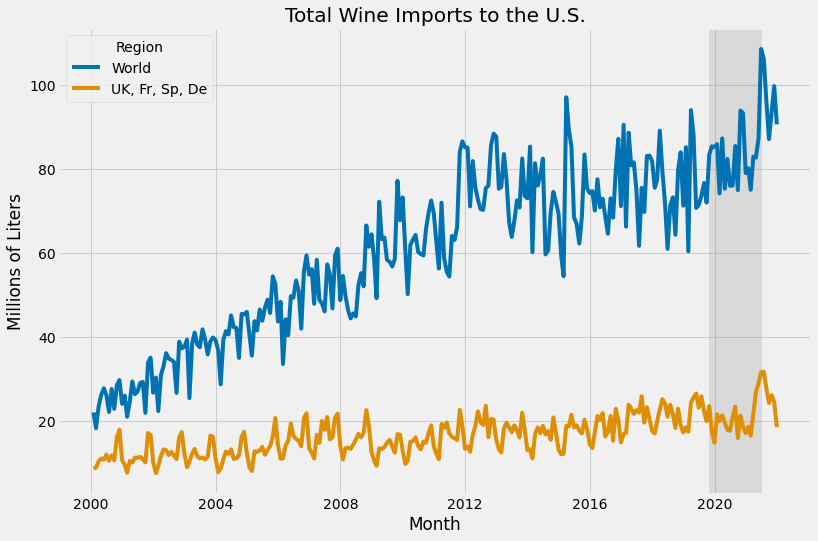

In [49]:
imports_quantity_plot = sns.lineplot(data=pd.melt(various_duties_df[['month', 'world_quantity', 'ukfrspde_quantity']], ['month']), x='month', y='value', hue='variable',)
imports_quantity_plot.set(title='Total Wine Imports to the U.S.', xlabel='Month', ylabel='Millions of Liters')
imports_quantity_plot.axvspan(
    xmin=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).first_valid_index()], 
    xmax=various_duties_df['month'].iloc[various_duties_df['month'].where(tariff_active).last_valid_index()], 
    color='gray', 
    alpha=0.2
)
imports_quantity_plot.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6)))
plt.gcf().set_size_inches(12, 8)

plt.legend(title='Region', loc='upper left', labels=['World', 'UK, Fr, Sp, De'])
plt.savefig('../figures/total-wine-imports-to-the-us.png')
plt.show()

#### U.S. Exports

First let's adjust for inflation and population.

In [50]:
exports_df['month'] = exports_df['month'].astype('datetime64[ns]')
exports_df = exports_df.merge(ppi_df, on='month')
exports_df = exports_df.merge(population_df[['month', 'population']], on='month')

exports_df['fas_value_adj'] = exports_df['FAS Value'] / exports_df['PCU3121303121300'] * 100
exports_df['quantity_per_capita'] = exports_df['First Unit of Quantity'] / exports_df['population']

exports_df.head()

,month,FAS Value,First Unit of Quantity,observation_date,PCU3121303121300,population,fas_value_adj,quantity_per_capita
0,2000-01-31,45525687,22385348,2000-01-01,103.0,281083000,44199696.116505,0.07964
1,2000-02-29,41336082,20954045,2000-02-01,101.1,281299000,40886332.344214,0.07449
2,2000-03-31,41446856,20240059,2000-03-01,103.0,281531000,40239666.019417,0.071893
3,2000-04-30,41411758,21745478,2000-04-01,101.0,281763000,41001740.594059,0.077176
4,2000-05-31,42672115,22059299,2000-05-01,101.9,281996000,41876462.217861,0.078226


In [51]:
display(exports_df.head())
display(exports_df.describe())
display(exports_df.info())

,month,FAS Value,First Unit of Quantity,observation_date,PCU3121303121300,population,fas_value_adj,quantity_per_capita
0,2000-01-31,45525687,22385348,2000-01-01,103.0,281083000,44199696.116505,0.07964
1,2000-02-29,41336082,20954045,2000-02-01,101.1,281299000,40886332.344214,0.07449
2,2000-03-31,41446856,20240059,2000-03-01,103.0,281531000,40239666.019417,0.071893
3,2000-04-30,41411758,21745478,2000-04-01,101.0,281763000,41001740.594059,0.077176
4,2000-05-31,42672115,22059299,2000-05-01,101.9,281996000,41876462.217861,0.078226


,PCU3121303121300,population
count,264.000000,2.640000e+02
mean,116.571076,3.093217e+08
std,9.456620,1.525593e+07
min,100.900000,2.810830e+08
25%,105.925000,2.960138e+08
50%,118.800000,3.109405e+08
75%,123.175000,3.231120e+08
max,134.442000,3.318950e+08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   month                   264 non-null    datetime64[ns]
 1   FAS Value               264 non-null    object        
 2   First Unit of Quantity  264 non-null    object        
 3   observation_date        264 non-null    datetime64[ns]
 4   PCU3121303121300        264 non-null    float64       
 5   population              264 non-null    int64         
 6   fas_value_adj           264 non-null    object        
 7   quantity_per_capita     264 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 18.6+ KB


None

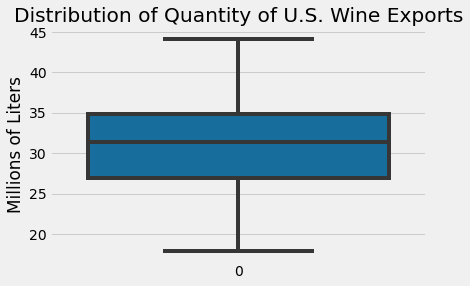

In [52]:
exports_quantity_boxplot = sns.boxplot(data=exports_df['First Unit of Quantity'] / 1000000)
exports_quantity_boxplot.set(title='Distribution of Quantity of U.S. Wine Exports', ylabel='Millions of Liters')
plt.show()

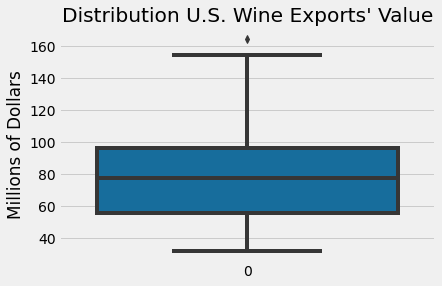

In [53]:
exports_value_boxplot = sns.boxplot(data=exports_df['fas_value_adj'] / 1000000)
exports_value_boxplot.set(title='Distribution U.S. Wine Exports\' Value', ylabel='Millions of Dollars')
plt.show()

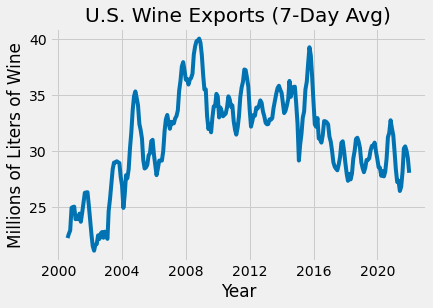

In [54]:
exports_df['first_unit_of_quantity_millions'] = exports_df['First Unit of Quantity'].astype('f4') / 1000000
exports_df['quantity_in_mil_rolling_avg_7'] = exports_df.first_unit_of_quantity_millions.rolling(7).mean()

exports_quantity_plot = sns.lineplot(data=exports_df, x='month', y='quantity_in_mil_rolling_avg_7')
exports_quantity_plot.set(title='U.S. Wine Exports (7-Day Avg)', ylabel='Millions of Liters of Wine', xlabel='Year')
plt.show()

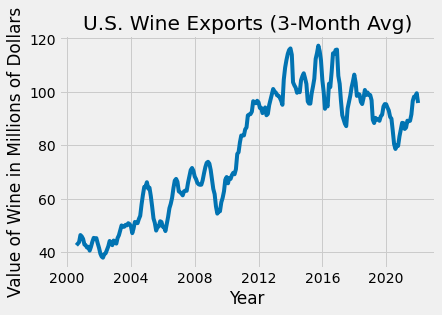

In [55]:
exports_df['fas_value_millions'] = exports_df['fas_value_adj'].astype('f4') / 1000000
exports_df['fas_value_millions_rolling_avg_7'] = exports_df.fas_value_millions.rolling(7).mean()

exports_quantity_plot = sns.lineplot(data=exports_df, x='month', y='fas_value_millions_rolling_avg_7')
exports_quantity_plot.set(title='U.S. Wine Exports (3-Month Avg)', ylabel='Value of Wine in Millions of Dollars', xlabel='Year')
plt.show()

#### Domestic Production

This data is provided by the Alcohol and Tobacco Tax and Trade Bureau (TTB). The data is in gallons instead of liters. Before looking into it, I'm going to quickly convert the timestamp to be the last day of the month and the values to be in liters instead of gallons.

In [56]:
def galons_to_liters(g):
    if math.isnan(g):
        return
    return g * 3.785411784

In [57]:
production_df['month'] = production_df['month'].astype(str).map(lambda x: last_day_of_month(x))
production_df['month'] = production_df['month'].astype('datetime64[ns]')

for c in ['bulk', 'bottled', 'cider', 'effervescent', 'wine_gross']:
    production_df[c] = production_df[c].map(lambda x: galons_to_liters(x))

Now let's adjust for per-capita rates.

In [58]:
production_df = production_df.merge(population_df[['month', 'population']], on='month')
for c in production_df.columns:
    if c != 'month' and c != 'population':
        col_name = c + '_adj'
        production_df[col_name] = production_df[c] / production_df['population']

In [59]:
display(production_df.head())
display(production_df.describe())
display(production_df.info())

,month,bulk,bottled,cider,effervescent,wine_gross,population,bulk_adj,bottled_adj,cider_adj,effervescent_adj,wine_gross_adj
0,2000-01-31,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,281083000,0.402552,0.442599,NaN,0.024581,0.869731
1,2000-02-29,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,281299000,0.255222,0.488904,NaN,0.015560,0.759686
2,2000-03-31,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,281531000,0.164658,0.569684,NaN,0.033110,0.767452
3,2000-04-30,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,281763000,0.117003,0.505036,0.007258,0.027970,0.642752
4,2000-05-31,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,281996000,0.112698,0.571873,0.024680,0.022464,0.682355


,bulk,bottled,cider,effervescent,wine_gross,population,bulk_adj,bottled_adj,cider_adj,effervescent_adj,wine_gross_adj
count,2.620000e+02,2.620000e+02,2.590000e+02,2.620000e+02,2.640000e+02,2.640000e+02,262.000000,262.000000,259.000000,262.000000,264.000000
mean,2.366476e+08,1.929920e+08,7.290981e+06,8.266621e+06,4.274359e+08,3.093217e+08,0.762839,0.621356,0.022790,0.026546,1.377695
std,2.329463e+08,3.586958e+07,6.452561e+06,2.698712e+06,2.328960e+08,1.525593e+07,0.749701,0.093725,0.019675,0.007954,0.741864
min,2.661546e+07,1.244070e+08,5.490210e+05,2.678186e+06,0.000000e+00,2.810830e+08,0.090648,0.442599,0.001865,0.009267,0.000000
25%,4.742184e+07,1.640341e+08,1.826624e+06,6.121333e+06,2.391613e+08,2.960138e+08,0.156859,0.550870,0.006125,0.020363,0.782410
50%,1.180365e+08,1.899242e+08,2.811740e+06,8.068083e+06,3.199454e+08,3.109405e+08,0.377495,0.611718,0.009091,0.026252,1.034645
75%,4.498815e+08,2.169504e+08,1.328316e+07,1.011393e+07,6.190754e+08,3.231120e+08,1.410859,0.678556,0.040792,0.032392,1.999028
max,8.200452e+08,3.474637e+08,2.140858e+07,1.481254e+07,1.019108e+09,3.318950e+08,2.622399,1.112624,0.066741,0.046178,3.258976


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   month             264 non-null    datetime64[ns]
 1   bulk              262 non-null    float64       
 2   bottled           262 non-null    float64       
 3   cider             259 non-null    float64       
 4   effervescent      262 non-null    float64       
 5   wine_gross        264 non-null    float64       
 6   population        264 non-null    int64         
 7   bulk_adj          262 non-null    float64       
 8   bottled_adj       262 non-null    float64       
 9   cider_adj         259 non-null    float64       
 10  effervescent_adj  262 non-null    float64       
 11  wine_gross_adj    264 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 26.8 KB


None

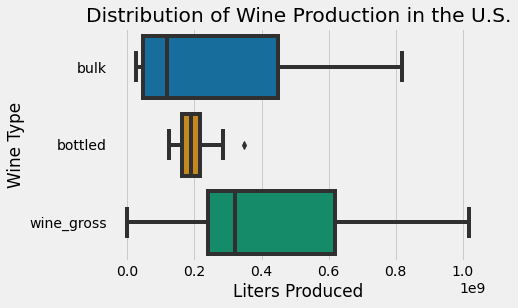

In [60]:
wine_prod_boxplot_df = pd.melt(production_df[['bulk', 'bottled', 'wine_gross']])
wine_prod_boxplot = sns.boxplot(data=wine_prod_boxplot_df, y='variable', x='value')
wine_prod_boxplot.set(title='Distribution of Wine Production in the U.S.', xlabel='Liters Produced', ylabel='Wine Type')
plt.show()

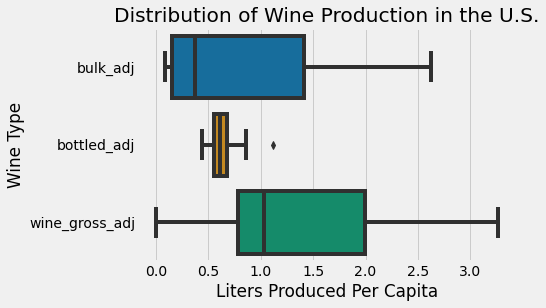

In [61]:
wine_prod_boxplot_adj_df = pd.melt(production_df[['bulk_adj', 'bottled_adj', 'wine_gross_adj']])
wine_prod_boxplot_adj = sns.boxplot(data=wine_prod_boxplot_adj_df, y='variable', x='value')
wine_prod_boxplot_adj.set(title='Distribution of Wine Production in the U.S.', xlabel='Liters Produced Per Capita', ylabel='Wine Type')
plt.show()

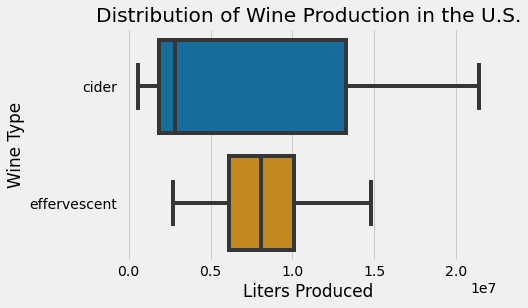

In [62]:
wine_prod_alt_boxplot_df = pd.melt(production_df[['cider', 'effervescent']])
wine_prod_alt_boxplot = sns.boxplot(data=wine_prod_alt_boxplot_df, y='variable', x='value')
wine_prod_alt_boxplot.set(title='Distribution of Wine Production in the U.S.', xlabel='Liters Produced', ylabel='Wine Type')
plt.show()

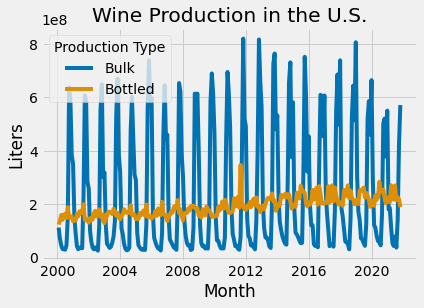

In [63]:
production_quantity_plot = sns.lineplot(data=pd.melt(production_df[['month', 'bulk', 'bottled']], ['month']), x='month', y='value', hue='variable',)
production_quantity_plot.set(title='Wine Production in the U.S.', xlabel='Month', ylabel='Liters')

plt.legend(title='Production Type', loc='upper left', labels=['Bulk', 'Bottled'])
plt.show()

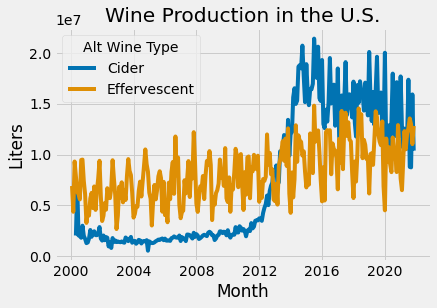

In [64]:
production_quantity_plot = sns.lineplot(data=pd.melt(production_df[['month', 'cider', 'effervescent']], ['month']), x='month', y='value', hue='variable',)
production_quantity_plot.set(title='Wine Production in the U.S.', xlabel='Month', ylabel='Liters')

plt.legend(title='Alt Wine Type', loc='upper left', labels=['Cider', 'Effervescent'])
plt.show()

#### Average Wine Prices in U.S. Cities

This data is retrieved from the federal reserve (FRED).

In [65]:
# Standardize dates
wine_prices_df['month'] = wine_prices_df['month'].map(lambda x: last_day_of_month(x))
wine_prices_df['month'] = wine_prices_df['month'].astype('datetime64[ns]')

# Adjust for inflation
wine_prices_df = wine_prices_df.merge(ppi_df, on='month')
wine_prices_df['price_adj'] = wine_prices_df['price'] / exports_df['PCU3121303121300'] * 100

In [66]:
display(wine_prices_df.head())
display(wine_prices_df.describe())
display(wine_prices_df.info())

,month,price,observation_date,PCU3121303121300,price_adj
0,2000-01-31,5.458,2000-01-01,103.0,5.299029
1,2000-02-29,5.256,2000-02-01,101.1,5.198813
2,2000-03-31,5.471,2000-03-01,103.0,5.311650
3,2000-04-30,5.156,2000-04-01,101.0,5.104950
4,2000-05-31,5.530,2000-05-01,101.9,5.426889


,price,PCU3121303121300,price_adj
count,265.000000,265.000000,264.000000
mean,9.754479,116.637834,8.241252
std,2.583417,9.501049,1.652331
min,5.156000,100.900000,5.104950
25%,7.399000,106.000000,6.774410
50%,10.035000,118.800000,8.631385
75%,12.203000,123.400000,9.803208
max,14.420000,134.442000,11.848809


<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   month             265 non-null    datetime64[ns]
 1   price             265 non-null    float64       
 2   observation_date  265 non-null    datetime64[ns]
 3   PCU3121303121300  265 non-null    float64       
 4   price_adj         264 non-null    float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 20.5 KB


None

[Text(0.5, 1.0, 'U.S. Wine Prices (7-Day Avg)'),
 Text(0, 0.5, 'Dollars'),
 Text(0.5, 0, 'Year')]

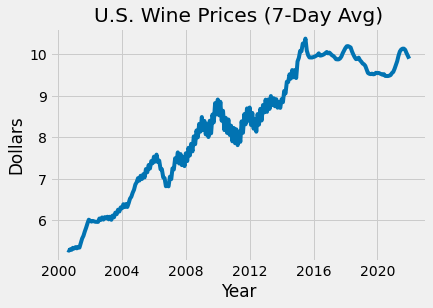

In [67]:
wine_prices_df['prices_rolling_avg_7'] = wine_prices_df.price_adj.rolling(7).mean()

wine_prices_plot = sns.lineplot(data=wine_prices_df, x='month', y='prices_rolling_avg_7')
wine_prices_plot.set(title='U.S. Wine Prices (7-Day Avg)', ylabel='Dollars', xlabel='Year')

## Combine Datasets

Construct a master dataset.

In [68]:
tariff_df.head()

,month,frspger_25
0,2000-01,0
1,2000-02,0
2,2000-03,0
3,2000-04,0
4,2000-05,0


In [69]:
master_df = pd.DataFrame()
master_df['month'] = months

# Population
master_df = master_df.merge(population_df[['month', 'population']], on='month')

# Prices
master_df = master_df.merge(wine_prices_df[['month', 'price', 'price_adj']], on='month')

# Disposable Income
master_df = master_df.merge(disposable_income_df[['month', 'di']], on='month')

# Domestic Production
master_df = master_df.merge(production_df[['month', 'bulk', 'bottled', 'cider', 'effervescent', 'wine_gross', 'bulk_adj', 'bottled_adj', 'cider_adj', 'effervescent_adj', 'wine_gross_adj']], on='month')

# Merge in top 3 countries datapoints
master_df = master_df.merge(top_three_df, on='month')

# Exports
## renaming columns
exports_df.rename(columns={
    'First Unit of Quantity':'quantity_exports',
    'fas_value_adj': 'fas_value_adj_exports'
    }, inplace=True)
## merging
master_df = master_df.merge(exports_df[['month', 'quantity_exports', 'fas_value_adj_exports']], on='month')

# Imports
## renaming world imports columns
imports_world_df.rename(columns={
    'Dutiable Value':'dutiable_value_world_imports',
    'dutiable_value_adj':'dutiable_value_adj_world_imports',
    'Landed Duty-Paid Value': 'landed_duty_paid_value_world_imports',
    'landed_duty_paid_value_adj': 'landed_duty_paid_value_adj_world_imports',
    'Customs Value': 'customs_value_world_imports',
    'customs_value_adj': 'customs_value_adj_world_imports',
    'First Unit of Quantity': 'quantity_world_imports',
    'Charges, Insurance, and Freight': 'charges_insurance_freight_world_imports',
    'charges_insurance_and_freight_adj': 'charges_insurance_freight_adj_world_imports',
    'Calculated Duties': 'calculated_duties_world_imports',
    'calculated_duties_adj': 'calculated_duties_adj_world_imports'
    }, inplace=True)
## renaming ukspfrde imports columns
imports_ukfrspde_df.rename(columns={
    'Dutiable Value':'dutiable_value_ukfrspde_imports',
    'dutiable_value_adj':'dutiable_value_adj_ukfrspde_imports',
    'Landed Duty-Paid Value': 'landed_duty_paid_value_ukfrspde_imports',
    'landed_duty_paid_value_adj': 'landed_duty_paid_value_adj_ukfrspde_imports',
    'Customs Value': 'customs_value_ukfrspde_imports',
    'customs_value_adj': 'customs_value_adj_ukfrspde_imports',
    'First Unit of Quantity': 'quantity_ukfrspde_imports',
    'Charges, Insurance, and Freight':'charges_insurance_freight_ukfrspde_imports',
    'charges_insurance_and_freight_adj':'charges_insurance_freight_adj_ukfrspde_imports',
    'Calculated Duties': 'calculated_duties_ukfrspde_imports',
    'calculated_duties_adj': 'calculated_duties_adj_ukfrspde_imports'
    }, inplace=True)
## merging
master_df = master_df.merge(imports_world_df[['month', 'dutiable_value_world_imports', 
    'dutiable_value_adj_world_imports', 'landed_duty_paid_value_world_imports', 
    'landed_duty_paid_value_adj_world_imports', 'customs_value_world_imports', 
    'customs_value_adj_world_imports', 'quantity_world_imports', 
    'charges_insurance_freight_world_imports', 'charges_insurance_freight_adj_world_imports', 
    'calculated_duties_world_imports', 'calculated_duties_adj_world_imports']], on='month')
master_df = master_df.merge(imports_ukfrspde_df[['month', 'dutiable_value_ukfrspde_imports', 
    'dutiable_value_adj_ukfrspde_imports', 'landed_duty_paid_value_ukfrspde_imports', 
    'landed_duty_paid_value_adj_ukfrspde_imports', 'customs_value_ukfrspde_imports', 
    'customs_value_adj_ukfrspde_imports', 'quantity_ukfrspde_imports', 
    'charges_insurance_freight_ukfrspde_imports', 'charges_insurance_freight_adj_ukfrspde_imports', 
    'calculated_duties_ukfrspde_imports', 'calculated_duties_adj_ukfrspde_imports']], on='month')

# Tariff Enacted Boolean
tariff_df['month'] = tariff_df['month'].map(lambda x: last_day_of_month(str(x)))
tariff_df['month'] = tariff_df['month'].astype('datetime64[ns]')
master_df = master_df.merge(tariff_df, on='month')

The dataset looks pretty good. I'll export this as an excel file just to hold on to it as is.

In [70]:
display(master_df.head())
display(master_df.describe())
display(master_df.info())

,month,population,price,price_adj,di,bulk,bottled,cider,effervescent,wine_gross,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
0,2000-01-31,281083000,5.458,5.299029,9309.1,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,...,59812261,58070156.31068,56706027,55054395.145631,8768676,2406931,2336826.213592,699303,678934.951456,0
1,2000-02-29,281299000,5.256,5.198813,9345.2,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,...,77087577,76248839.762611,73873201,73069437.1909,8961916,2356486,2330846.686449,857890,848555.885262,0
2,2000-03-31,281531000,5.471,5.311650,9370.3,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,...,87219165,84678800.970874,83500840,81068776.699029,10474993,2804317,2722637.864078,914008,887386.407767,0
3,2000-04-30,281763000,5.156,5.104950,9418.3,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,...,87040067,86178284.158416,83075769,82253236.633663,11128077,2989501,2959901.980198,974797,965145.544554,0
4,2000-05-31,281996000,5.530,5.426889,9457.3,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,...,79534639,78051657.50736,75599523,74189914.622179,10874051,3037785,2981143.277723,897331,880599.607458,0


,population,price,price_adj,di,bulk,bottled,cider,effervescent,wine_gross,bulk_adj,...,calculated_duties_adj_chile_imports,dutiable_value_chile_imports,dutiable_value_adj_chile_imports,landed_duty_paid_value_chile_imports,landed_duty_paid_value_adj_chile_imports,quantity_chile_imports,quantity_adj_chile_imports,customs_value_chile_imports,customs_value_adj_chile_imports,frspger_25
count,2.640000e+02,264.000000,264.000000,264.000000,2.620000e+02,2.620000e+02,2.590000e+02,2.620000e+02,2.640000e+02,262.000000,...,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,264.000000
mean,3.093217e+08,9.740682,8.241252,12292.750379,2.366476e+08,1.929920e+08,7.290981e+06,8.266621e+06,4.274359e+08,0.762839,...,2.460730e+05,1.182176e+07,1.037347e+07,2.088543e+07,1.770888e+07,8.775427e+06,7.348314e+06,1.909732e+07,1.618633e+07,0.079545
std,1.525593e+07,2.578523,1.652331,1843.265578,2.329463e+08,3.586958e+07,6.452561e+06,2.698712e+06,2.328960e+08,0.749701,...,2.091269e+05,9.282460e+06,7.816296e+06,7.082182e+06,5.324919e+06,4.630562e+06,3.554565e+06,6.499507e+06,4.877296e+06,0.271102
min,2.810830e+08,5.156000,5.104950,9309.100000,2.661546e+07,1.244070e+08,5.490210e+05,2.678186e+06,0.000000e+00,0.090648,...,4.133114e+02,1.027100e+05,8.439606e+04,8.462704e+06,8.387219e+06,3.256876e+06,3.092771e+06,7.575590e+06,7.508018e+06,0.000000
25%,2.960138e+08,7.386500,6.774410,10835.350000,4.742184e+07,1.640341e+08,1.826624e+06,6.121333e+06,2.391613e+08,0.156859,...,9.096907e+03,8.306312e+05,6.674602e+05,1.468109e+07,1.354883e+07,4.678448e+06,4.365015e+06,1.338446e+07,1.234488e+07,0.000000
50%,3.109405e+08,10.025000,8.631385,12052.050000,1.180365e+08,1.899242e+08,2.811740e+06,8.068083e+06,3.199454e+08,0.377495,...,2.576197e+05,1.221642e+07,1.157018e+07,1.976932e+07,1.659045e+07,7.666642e+06,6.243503e+06,1.830817e+07,1.514277e+07,0.000000
75%,3.231120e+08,12.197750,9.803208,13552.175000,4.498815e+08,2.169504e+08,1.328316e+07,1.011393e+07,6.190754e+08,1.410859,...,3.386923e+05,1.776843e+07,1.544753e+07,2.613591e+07,2.151359e+07,1.232563e+07,9.841263e+06,2.394190e+07,1.976328e+07,0.000000
max,3.318950e+08,14.420000,11.848809,19119.500000,8.200452e+08,3.474637e+08,2.140858e+07,1.481254e+07,1.019108e+09,2.622399,...,1.137481e+06,4.030882e+07,3.387296e+07,4.646469e+07,3.904596e+07,2.238199e+07,1.880840e+07,4.264430e+07,3.583554e+07,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 76 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   month                                            264 non-null    datetime64[ns]
 1   population                                       264 non-null    int64         
 2   price                                            264 non-null    float64       
 3   price_adj                                        264 non-null    float64       
 4   di                                               264 non-null    float64       
 5   bulk                                             262 non-null    float64       
 6   bottled                                          262 non-null    float64       
 7   cider                                            259 non-null    float64       
 8   effervescent                            

None

In [71]:
master_df.to_excel('../data/master-data.xlsx')